#### Maps for Merry

Make pretty MUSE maps for Merry's CARS/*Chandra* paper. 

Grant R. Tremblay (Center for Astrophysics | Harvard & Smithsonian)

In [611]:
import os
import sys
import glob

import warnings
warnings.filterwarnings('ignore') # Some things we'll be doing throw runtimewarnings that we won't care about. 

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.wcs import WCS
import astropy.constants as const
import astropy.units as u
from astropy.visualization import astropy_mpl_style

import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

### This is magic for Jupyer Notebooks. 
### Delete if putting into a script!
%matplotlib inline 
#######################################

import imageio

In [612]:
def styleplots():
    """
    Make plots pretty and labels clear.
    """
    plt.style.use('ggplot')

    labelsizes = 20

    plt.rcParams['font.size'] = labelsizes
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['axes.titlesize'] = labelsizes
    plt.rcParams['axes.labelsize'] = labelsizes
    plt.rcParams['xtick.labelsize'] = labelsizes
    plt.rcParams['ytick.labelsize'] = labelsizes
    
styleplots()

In [613]:
user_home_directory = os.path.expanduser("~/")

cars_data_directory = 'data/'
file_save_directory = user_home_directory + "Desktop/merry_files/"

In [614]:
os.listdir(cars_data_directory)

['HE0227-0913.eline_table.fits',
 'HE0227-0913.kin_table.fits',
 'HE0227-0913_FOV_SDSSi.fits',
 'HE0351+0240.eline_table.fits',
 'HE0351+0240.kin_table.fits',
 'HE0351+0240_FOV_SDSSi.fits']

### Setup

In [615]:
he0227_redshift = 0.0165
he0351_redshift = 0.034

In [616]:
he0227_fovimage = cars_data_directory + "HE0227-0913_FOV_SDSSi.fits"
he0351_fovimage = cars_data_directory + "HE0351+0240_FOV_SDSSi.fits"

In [617]:
def show_fovimage(fovimage, name, vmin=0.001, vmax=0.5, cmap=cm.magma, nanthresh=0.0, nancolor='white'):
    '''Show a collapsed MUSE image.'''
    
    data = fits.getdata(fovimage)
    wcs = WCS(fits.getheader(fovimage, 1))
    
    data[data < nanthresh] = np.nan
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=wcs)

    ax.coords[0].set_axislabel('Right Ascension')
    ax.coords[1].set_axislabel('Declination')

    cmap.set_bad(nancolor) # We set NaNs to be white here. 

    ax.set_title('{} \nCollapsed MUSE Image'.format(name))

    ax.tick_params(labelsize=14)

    frame = ax.imshow(data, origin='lower', norm=LogNorm(), vmin=vmin, vmax=vmax, cmap=cmap, interpolation='None')
    

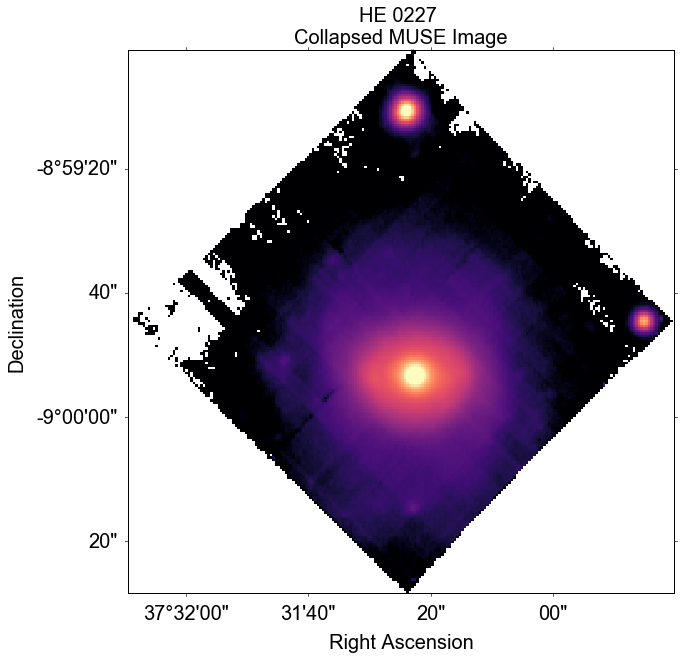

In [618]:
show_fovimage(he0227_fovimage, name="HE 0227")

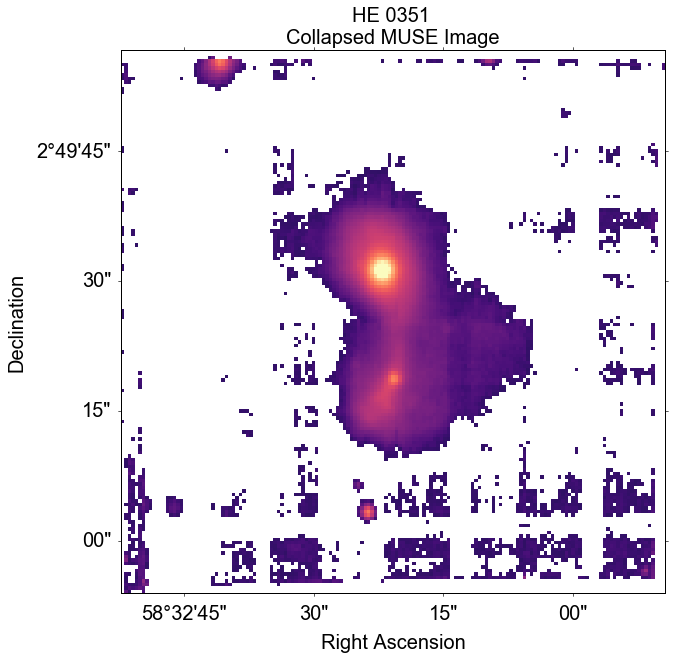

In [619]:
show_fovimage(he0351_fovimage, "HE 0351", nanthresh=0.003)

#### Make Stellar Velocity Maps

In [620]:
he0227_kintable = cars_data_directory + 'HE0227-0913.kin_table.fits'
he0351_kintable = cars_data_directory + 'HE0351+0240.kin_table.fits'

In [663]:
def make_stars(kintable, fovimage, redshift, name, snthresh=100, velocity_thresh=None, project_by_median=True, project_by_redshift=False, cropbox=None, zoom=False, zoombox=None, wcs=True, nancolor='white', colorbar_scalefactor=0.047, vmin=-500, vmax=500, save=True, file_save_directory="./"):
    
    table = fits.getdata(kintable)
    #hdr = fits.getheader(fovimage)
    
    x = table['x_cor']
    y = table['y_cor']
    
    # Get the 2D dimensions into which you'll paint this data
    fovdata = fits.getdata(fovimage)
    dim = fovdata.shape
    
    # Make empty maps of NaNs
    velmap = np.full((dim[0], dim[1]), np.nan)
    dispmap = np.full((dim[0], dim[1]), np.nan)
    
    # Threshold & Crop
    if velocity_thresh is not None:
        mask = (table['vel_fit'] / table['vel_fit_err'] > snthresh) & (table['vel_fit'] < np.nanmedian(table['vel_fit'] + velocity_thresh)) & (table['vel_fit'] > np.nanmedian(table['vel_fit'] - velocity_thresh))
    else:
        mask = table['vel_fit'] / table['vel_fit_err'] > snthresh
    
    velmap[x[mask], y[mask]] = table['vel_fit'][mask]
    dispmap[x[mask], y[mask]] = table['disp_fit'][mask]
    
    if cropbox is not None:
        x1, x2, y1, y2 = cropbox 

        # YES, you should be confused by the below line. 
        # This is *inverted* for the actual mask, but NOT for the zoom. 
        # So what the user would naturally expect to be x1 is actually y1
        keep = (x > y1) & (x < y2) & (y > x1) & (y < x2) # YES
        crop = np.logical_not(keep)
    
    velmap[x[crop], y[crop]] = np.nan
    dispmap[x[crop], y[crop]] = np.nan 


    if project_by_redshift is True:
        if project_by_median is True:
            project_by_median = False
            print("project_by_redshift=True which overrides project_by_median=True")
        velmap = velmap - redshift * const.c.to(u.km / u.s).value
    if project_by_median is True:
        redshift = np.nanmedian(velmap) / const.c.to(u.km / u.s).value
        velmap = velmap - np.nanmedian(velmap)
    
    # Make both figures

    if wcs is True:
        wcs = WCS(fits.getheader(fovimage, 1))
        #fig = plt.figure(figsize=(10,10))
        fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, subplot_kw=dict(projection=wcs))
        #ax = plt.subplot(projection=wcs)
        #ax.coords[0].set_axislabel('Right Ascension')
        #ax.coords[1].set_axislabel('Declination')
        
    elif wcs is False:
        fig, ax = plt.subplots(figsize=(10,10))
    
    ax.grid(False)
    
    cmap_vel = cm.RdBu
    cmap_vel.set_bad(nancolor) 
    
    cmap_disp = cm.plasma
    cmap_disp.set_bad(nancolor)
    
    if project_by_median is True or project_by_redshift is True:
        im = plt.imshow(velmap, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap_vel, interpolation='nearest')
        cbar = plt.colorbar(im, fraction=colorbar_scalefactor, pad=0.01)
        cbar.set_label(r"Stellar Velocity (km/s) relative to z = {}".format(round(redshift, 4)))
    else:
        im = plt.imshow(velmap, origin='lower', cmap=cmap_vel, interpolation='nearest')
        cbar = plt.colorbar(im, fraction=colorbar_scalefactor, pad=0.01)
        cbar.set_label(r"Stellar Velocity (km/s)")
        vmin=None
        vmax=None
    
    if zoom is True:
        if zoombox is not None:
            x1, x2, y1, y2 = zoombox
            print("Zooming to {}".format(zoombox))
        elif zoombox is None and cropbox is not None:
            print("Using cropbox as zoombox")
        ax.set_xlim(x1, x2)
        ax.set_ylim(y1, y2)

    ax.grid(False)
    
    if save is True:
        # Check that the file save directory exists. If not, create it. 
        if not os.path.exists(file_save_directory):
            os.makedirs(file_save_directory)
            print("Creating file save directory: {}".format(file_save_directory))
        else:
            print("Found file save directory: {}".format(file_save_directory))
        
        # Save the PDF figure
        pdf_file = "{}_stellar_velocity.pdf".format(name.replace(" ", ""))
        fig.savefig(file_save_directory + pdf_file, dpi=300, bbox_inches='tight')
        print("Saved Stellar Velocity Map Figure to {}".format(pdf_file))
   
        # Save the FITS file
        vel_fits_file = "{}_stellar_velocity.fits".format(name.replace(" ", ""))
        hdr = WCS(fits.getheader(fovimage, 1)).to_header()
        hdu = fits.PrimaryHDU(velmap, header=hdr)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(file_save_directory + vel_fits_file, overwrite=True, output_verify='silentfix')
        print("Saved Stellar Velocity Map FITS image to {}".format(vel_fits_file))

    
#     if wcs is True:
#         wcs = WCS(fits.getheader(fovimage, 1))
#         fig = plt.figure(figsize=(10,10))
#         ax = plt.subplot(projection=wcs)
#         ax.coords[0].set_axislabel('Right Ascension')
#         ax.coords[1].set_axislabel('Declination')
#     elif wcs is False:
#         fig, ax = plt.subplots(figsize=(10,10))
    
#     ax.grid(False)
    
#     cmap_disp = cm.plasma
#     cmap_disp.set_bad(nancolor) 
    
#     im = plt.imshow(dispmap, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap_disp, interpolation='nearest')
#     cbar = plt.colorbar(im, fraction=colorbar_scalefactor, pad=0.01)
#     cbar.set_label(r"Stellar Velocity Dispersion (km/s)")
    
#     if zoom is True:
#         if zoombox is not None:
#             x1, x2, y1, y2 = zoombox
#             print("Zooming to {}".format(zoombox))
#         elif zoombox is None and cropbox is not None:
#             print("Using cropbox as zoombox")
#         ax.set_xlim(x1, x2)
#         ax.set_ylim(y1, y2)

#     ax.grid(False)
    
    if save is True:

        # Save the PDF figure
        pdf_file = "{}_stellar_dispersion.pdf".format(name.replace(" ", ""))
        fig.savefig(file_save_directory + pdf_file, dpi=300, bbox_inches='tight')
        print("Saved Stellar Velocity Dispersion Map Figure to {}".format(pdf_file))
        
        # Save the FITS figure, along with a WCS
        
        disp_fits_file = "{}_stellar_dispersion.fits".format(name.replace(" ", ""))
        
        disp_fits_file = "{}_stellar_dispersion.fits".format(name.replace(" ", ""))   
        hdu = fits.PrimaryHDU(dispmap, header=hdr)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(file_save_directory + disp_fits_file, overwrite=True, output_verify='silentfix')
        print("Saved Stellar Velocity Dispersion Map FITS image to {}".format(disp_fits_file))
          
        # Make Kinemetry Table
        
        kinemetry_table_filename = "{}_kinemetry_table.dat".format(name.replace(" ", ""))

        bin_number =np.arange(1, len(table["x_cor"][mask]) + 1)
        kinemetry_table = Table([bin_number, 
                                table["x_cor"][mask], 
                                table["y_cor"][mask], 
                                table["vel_fit"][mask], 
                                table["vel_fit_err"][mask], 
                                table["disp_fit"][mask], 
                                table["disp_fit_err"][mask]], 
                                names=["#", "XBIN", "YBIN", "VEL", "ER_VEL", "SIG", "ER_SIG"])  
        print("Saved Kinemetry Table to {}".format(kinemetry_table_filename)) 
        ascii.write(kinemetry_table, file_save_directory + kinemetry_table_filename, overwrite=True)
    

Using cropbox as zoombox
Found file save directory: /Users/grant/Desktop/merry_files/
Saved Stellar Velocity Map Figure to HE0227_stellar_velocity.pdf
Saved Stellar Velocity Map FITS image to HE0227_stellar_velocity.fits
Saved Stellar Velocity Dispersion Map Figure to HE0227_stellar_dispersion.pdf
Saved Stellar Velocity Dispersion Map FITS image to HE0227_stellar_dispersion.fits
Saved Kinemetry Table to HE0227_kinemetry_table.dat


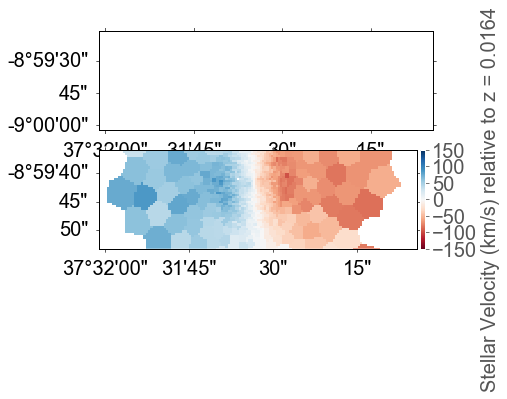

In [664]:
make_stars(he0227_kintable, 
                      he0227_fovimage, 
                      he0227_redshift, 
                      name = "HE 0227", 
                      snthresh=500,
                      velocity_thresh=200, # in km/s
                      cropbox=(20, 160, 65, 180), # (x1, x2, y1, y2),
                      zoom=True, # It will zoom on the cropbox
                      wcs=True,
                      vmin=-150,
                      vmax=150,
                      colorbar_scalefactor=0.039, # I'm too lazy to properly implement colorbar resizing
                      project_by_median=True,
                      project_by_redshift=False,
                      save=True,
                      file_save_directory=file_save_directory)

Found file save directory: /Users/grant/Desktop/merry_files/
Saved Stellar Velocity Map Figure to HE0351_stellar_velocity.pdf
Saved Stellar Velocity Map FITS image to HE0351_stellar_velocity.fits
Saved Stellar Velocity Dispersion Map Figure to HE0351_stellar_dispersion.pdf
Saved Stellar Velocity Dispersion Map FITS image to HE0351_stellar_dispersion.fits
Saved Kinemetry Table to HE0351_kinemetry_table.dat


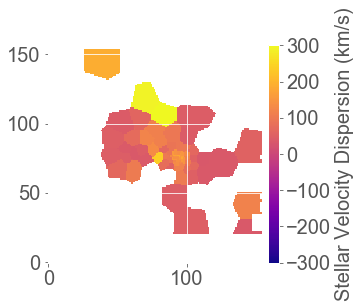

In [643]:
make_stars(he0351_kintable, 
                      he0351_fovimage, 
                      he0351_redshift, 
                      name = "HE 0351", 
                      snthresh=50,
                      velocity_thresh=300, # in km/s
                      cropbox=(20, 180, 20, 180), # (x1, x2, y1, y2),
                      zoom=False, # It will zoom on the cropbox
                      wcs=True,
                      vmin=-300,
                      vmax=300,
                      project_by_median=True,
                      project_by_redshift=False,
                      save=True,
                      file_save_directory=file_save_directory)